# Meteorological Observations and ERA5 comparison

__[Meteorological Observations From Regional Basic Synoptic Network (RBSN) ](http://data.planetos.com/datasets/noaa_rbsn_timeseries)__ is a set of meteorological observations collected by countries for the __[Global Observing System](http://www.wmo.int/pages/prog/www/OSY/GOS.html)__, which, according to WMO Resolution 40, is free to use. The same data is used by official meteorological institutions to inform public about weather, and they also form a basis of global climatological studies. Stations belonging to the network follow common guidelines for placement, which is important to assure that observations reflect actual meteorological, not microclimate, conditions. 
For current dataset, we collect raw observation data from several locations and apply our custom QA methods. Please refer to the Description section for up-to-date quality information

__[ERA5](http://data.planetos.com/datasets/ecmwf_era5)__ Climate reanalysis gives a numerical description of the recent climate, produced by combining models with observations. It contains estimates of atmospheric parameters such as air temperature, pressure and wind at different altitudes, and surface parameters such as rainfall, soil moisture content, sea-surface temperature and wave height.
ERA5 is the first reanalysis produced as an operational service and provides data at a considerably higher spatial and temporal resolution than its predecessor ERA-Interim.

In this Notebook we use the Planet OS ```package API```, ```raster API``` and also ```point API```, to fetch data. We analyze RBSN and ERA5 data by using temperature data. This time we are analyzing Colorado state, but we encourade you to change the location, selection of variables, and find your own results.

_API documentation is available at http://docs.planetos.com. If you have questions or comments, join the Planet OS Slack community to chat with our development team. For general information on usage of IPython/Jupyter and Matplotlib, please refer to their corresponding documentation. https://ipython.org/ and http://matplotlib.org/ _

In [1]:
%matplotlib notebook
import numpy as np
from dh_py_access import package_api
import dh_py_access.lib.datahub as datahub
import xarray as xr
import matplotlib.pyplot as plt
from po_data_process import get_data_from_raster_API,get_data_from_point_API
import warnings
from IPython.display import display, clear_output
import pandas as pd
import ipywidgets as widgets
from mpl_toolkits.basemap import Basemap
import json
from urllib.request import urlopen
warnings.filterwarnings("ignore")

<font color='red'>Please put your datahub API key into a file called APIKEY and place it to the notebook folder or assign your API key directly to the variable API_key!</font>

In [2]:
API_key = open('APIKEY').readlines()[0].strip() #'<YOUR API KEY HERE>'
version = 'v1'
server = "api.planetos.com"
dh=datahub.datahub(server,version,API_key)

At first, we need to define the dataset names and variables we want to use. This time we will use temperature variables.

We also define the location where we will compare ERA5 and RBSN data. Currently, we will do analyzis on Colorado state. 

In [3]:
dataset1='noaa_rbsn_timeseries'
dataset2='ecmwf_era5'

variables_rbsn = 'temperature'; 
var_era5 = '2_metre_temperature_surface'

area_name = 'colorado'
latitude_north = 41.01;latitude_south = 36.93
longitude_west = -109.12; longitude_east = -102.02


RBSN has almost 10 000 stations. Let's see how many there are in Planet OS Datahub.

In [4]:
stations_url = 'https://api.planetos.com/v1/datasets/{0}/stations?apikey={1}'.format(dataset1,API_key)
station_coordinates = json.loads(urlopen(stations_url).read().decode('utf-8'))['station']
longitude = np.asarray([station_coordinates[stat]['SpatialExtent']['coordinates'][0] for stat in station_coordinates if station_coordinates[stat]])
latitude = np.asarray([station_coordinates[stat]['SpatialExtent']['coordinates'][1] for stat in station_coordinates if station_coordinates[stat]])
print ('We have ' + str(len(station_coordinates)) + ' RBSN station data')

We have 9436 RBSN station data


Now we will put those stations on to the map. We can see that in the Europe there is the most stations, however, all the other continents are covered pretty well. 

<IPython.core.display.Javascript object>


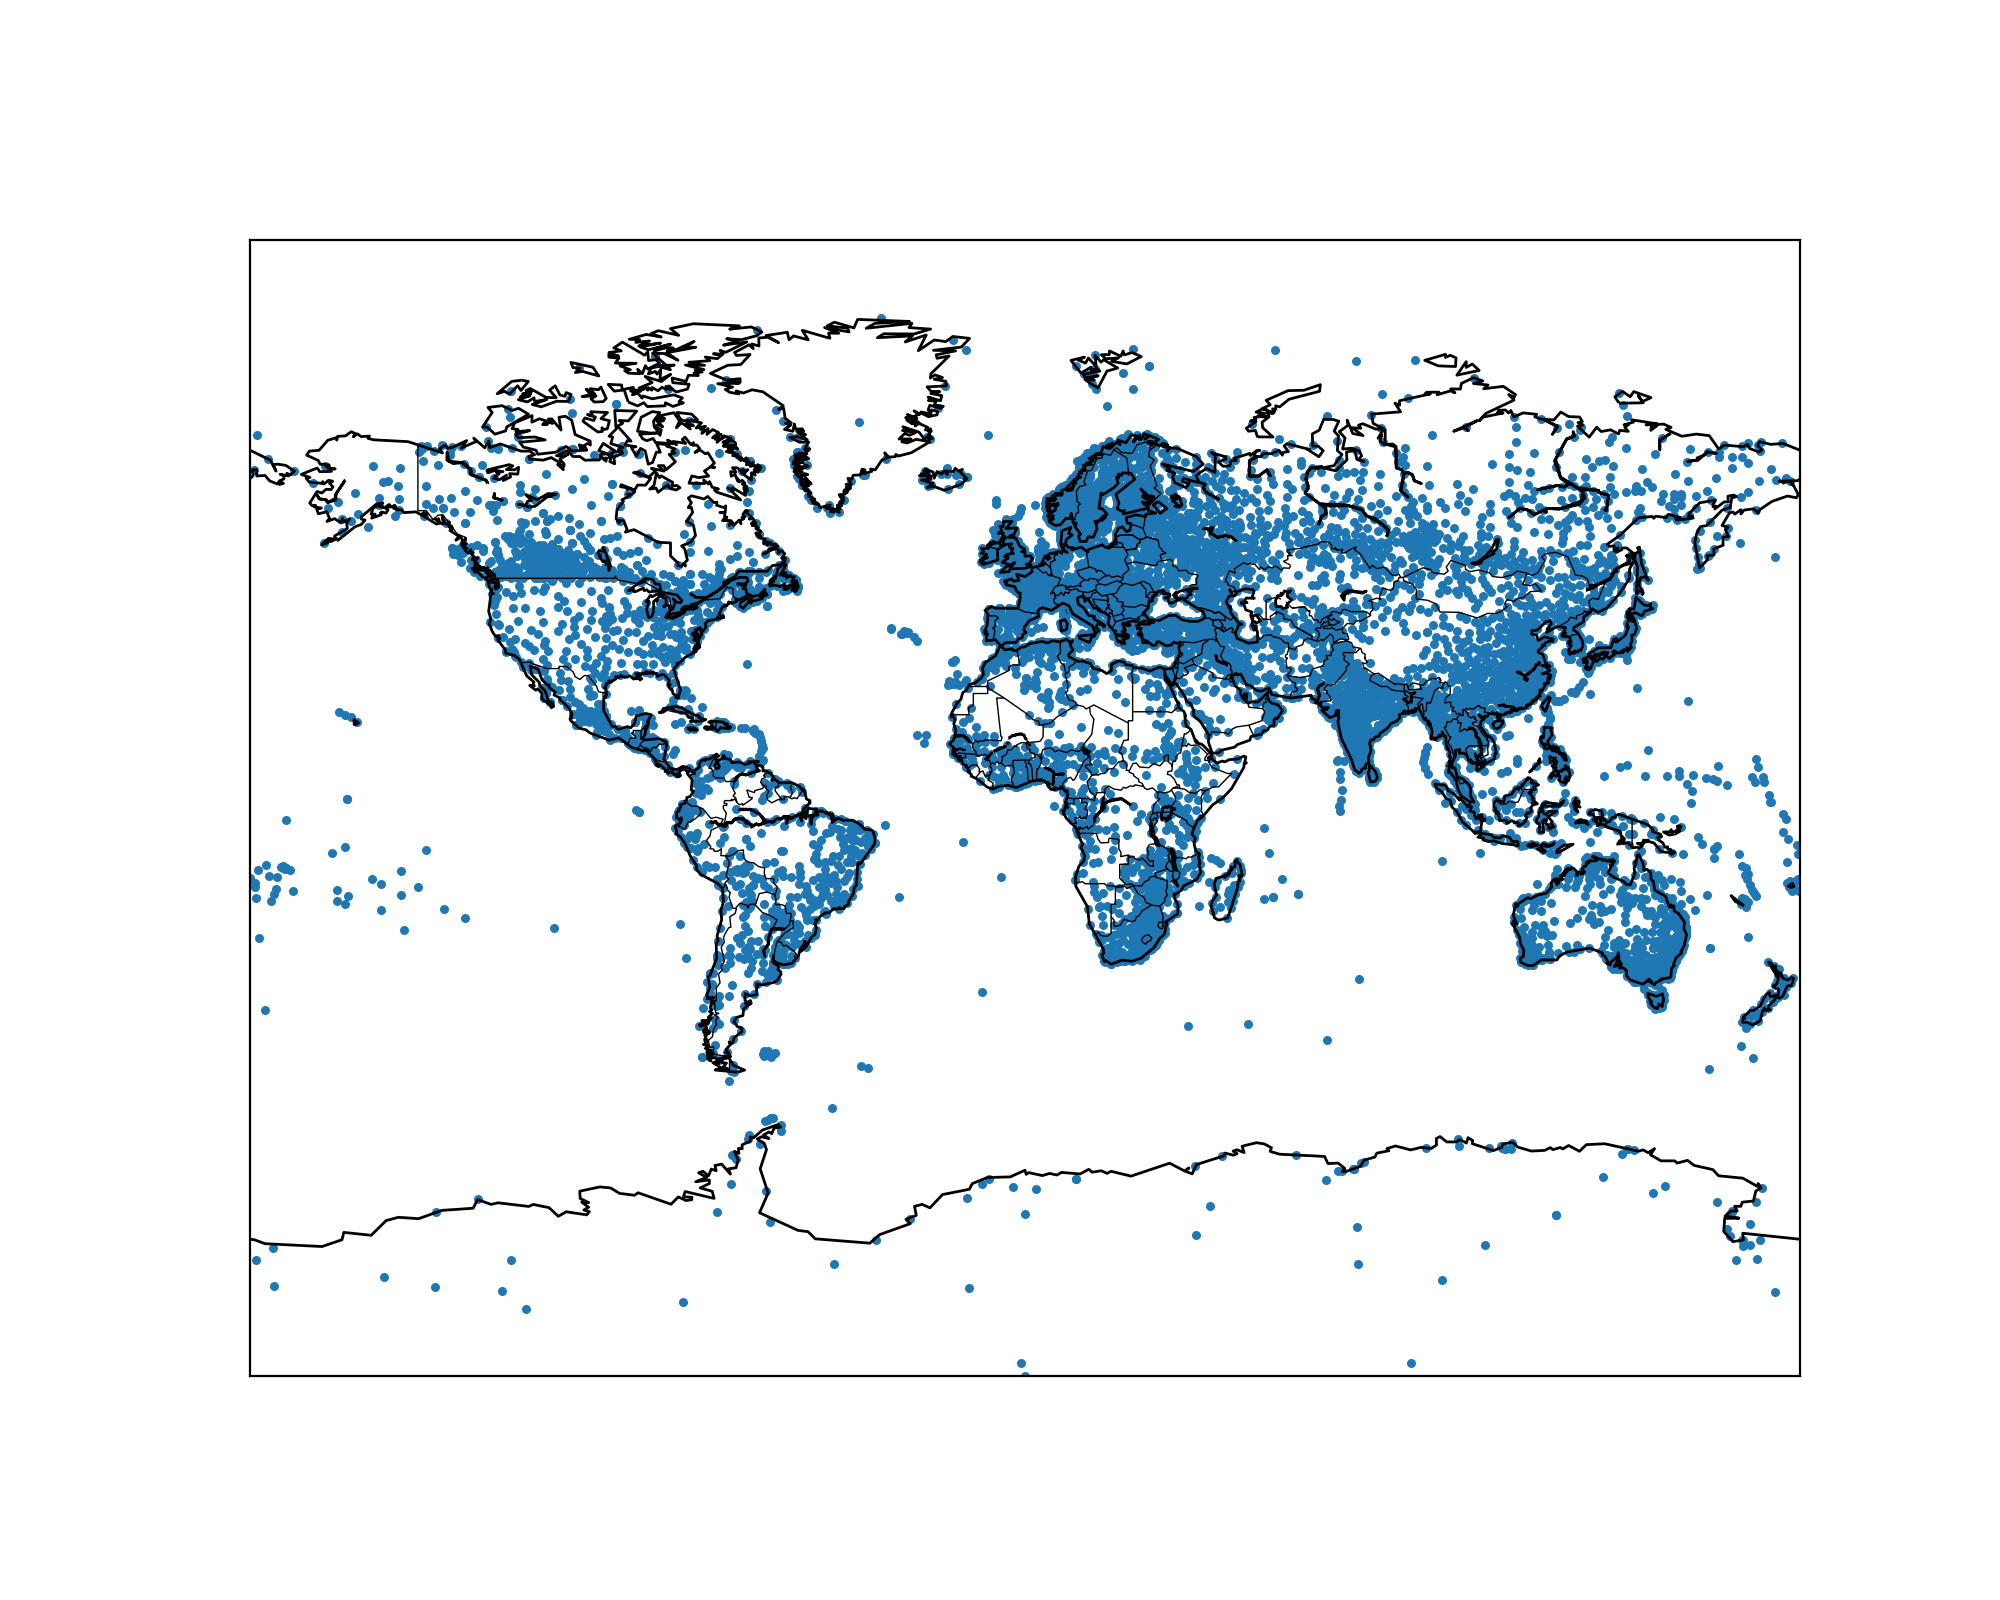

In [5]:
m = Basemap(projection='mill',lon_0=0)
#lons,lats = np.meshgrid(longitude,latitude)
lonmap,latmap = m(longitude,latitude)
fig=plt.figure(figsize=(10,8))
m.drawcoastlines()
m.drawcountries()
m.scatter(lonmap,latmap,5,marker='o')
plt.show()

Now we will choose ```analysis_time``` for the one time coparison. So, we will find out how data matches 2017-12-24 midnight. For that, at first we will get the RBSN data using raster API. 

In [6]:
analysis_time = '2017-12-24T00:00:00'
data_pd = get_data_from_raster_API(dataset1, longitude_west, latitude_south, longitude_east, latitude_north, 
                                   API_key,time_start = '2017-10-24T00:00:00', time_end='2017-12-31T00:00:00',
                                   var=variables_rbsn +',station_name,lon,lat')
station_data_specific_time = data_pd[data_pd['time'] == analysis_time]
station_data = {'time':data_pd['time'],'station_name':[s[0][0] for s in data_pd['station_name']],'lat':[l[0][1][0] for l in data_pd['indexAxes']],'lon':[l[1][1][0] for l in data_pd['indexAxes']],'temperature':[t[0][0] for t in data_pd['temperature']]}
rbsn_pd = pd.DataFrame(data=station_data)

For getting ERA5 data, we decided to use package API as it will be much faster when data volume gets higher.

So, at first let's create package object, create package itself and download it.

In [7]:
package = package_api.package_api(dh,dataset2,var_era5,longitude_west,longitude_east,latitude_south,latitude_north,time_start=analysis_time,time_end=analysis_time,area_name=area_name)
package.make_package()
package.download_package()

Package exists
File already downloaded


When package is downloaded, we use xarray for reading a file. Note that we will make some conversions for comparing with RBSN as well. First, longitude values were in 0 to 360 grid, but we want to have them in -180 to 180. And we will also convert temperature from Kelvins to Celsius.

In [8]:
dd1 = xr.open_dataset(package.local_file_name)
dd1['lon'] = ((dd1.lon+180) % 360) - 180
dd1['temp_celsius'] = dd1['2_metre_temperature_surface'] - 273.15

Now, data is read in. Let's plot it down to see differences. For plotting, at first we will define minimum and maximum values, because we want to have same colorscales for both datasets. And then we will use matplotlib pcolormesh(ERA5) and scatter(RBSN). 

On the plot, we can see temperature[C] data over Colorado state. There are five RBSN stations. ERA5 data shows quite good match with observational data. In all five locations RBSN and ERA5 data is very similar. 

<IPython.core.display.Javascript object>


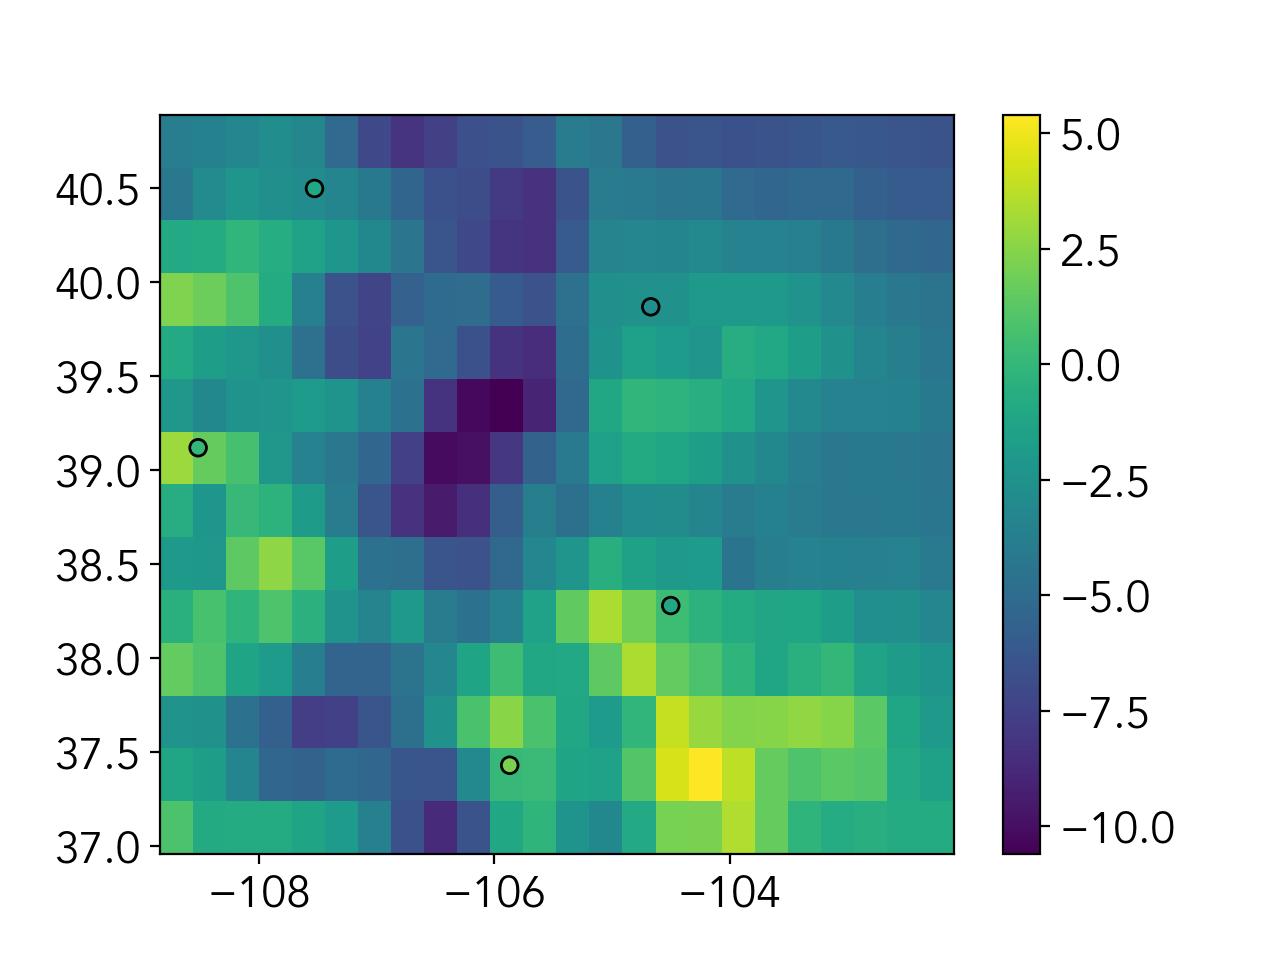

In [9]:
lat_rbsn = [l[0][1][0] for l in station_data_specific_time['indexAxes']]
lon_rbsn = [l[1][1][0] for l in station_data_specific_time['indexAxes']]
temp_rbsn = [v[0][0] for v in station_data_specific_time['temperature']]

vmin = dd1.variables['temp_celsius'].min() ; vmax = dd1.variables['temp_celsius'].max()
fig=plt.figure()
plt1 = plt.pcolormesh(dd1.lon,dd1.lat,dd1.variables['temp_celsius'][0,:,:], vmin = vmin, vmax = vmax)
plt2 = plt.scatter(lon_rbsn,lat_rbsn,c = temp_rbsn, vmin = vmin, vmax = vmax,edgecolors='black')
plt.colorbar(plt1)
plt.show()

As we saw on the plot above, there is five RBSN stations in Colorado state. Let's make dropdown from which to choose the sation for the timeseries comparison. 

In [10]:
## Download data for ERA5 for station locations
time_start = '2017-10-24T00:00:00'; time_end='2017-12-31T00:00:00'
droplist0 = list(np.unique(rbsn_pd.station_name))
stations = {i:rbsn_pd[rbsn_pd['station_name'] == i].iloc[0] for i in droplist0}
era5_pd = {k:get_data_from_point_API(dataset2, stations[k].lon, stations[k].lat, API_key,time_start = time_start,time_end = time_end, var=var_era5) for k in droplist0}
for k in era5_pd:
    era5_pd[k]['date'] = pd.to_datetime(era5_pd[k]['time'])
    era5_pd[k]['temp'] = era5_pd[k]['2_metre_temperature_surface']- 273.15

http://api.planetos.com/v1/datasets/ecmwf_era5/point?lat=37.43000030517578&lon=-105.87000274658203&apikey=8428878e4b944abeb84790e832c633fc&count=100000&z=all&verbose=False&time_start=2017-10-24T00:00:00&time_end=2017-12-31T00:00:00&var=2_metre_temperature_surface
http://api.planetos.com/v1/datasets/ecmwf_era5/point?lat=40.5&lon=-107.52999877929688&apikey=8428878e4b944abeb84790e832c633fc&count=100000&z=all&verbose=False&time_start=2017-10-24T00:00:00&time_end=2017-12-31T00:00:00&var=2_metre_temperature_surface
http://api.planetos.com/v1/datasets/ecmwf_era5/point?lat=39.869998931884766&lon=-104.66999816894531&apikey=8428878e4b944abeb84790e832c633fc&count=100000&z=all&verbose=False&time_start=2017-10-24T00:00:00&time_end=2017-12-31T00:00:00&var=2_metre_temperature_surface
http://api.planetos.com/v1/datasets/ecmwf_era5/point?lat=39.119998931884766&lon=-108.5199966430664&apikey=8428878e4b944abeb84790e832c633fc&count=100000&z=all&verbose=False&time_start=2017-10-24T00:00:00&time_end=2017-12-

<IPython.core.display.Javascript object>


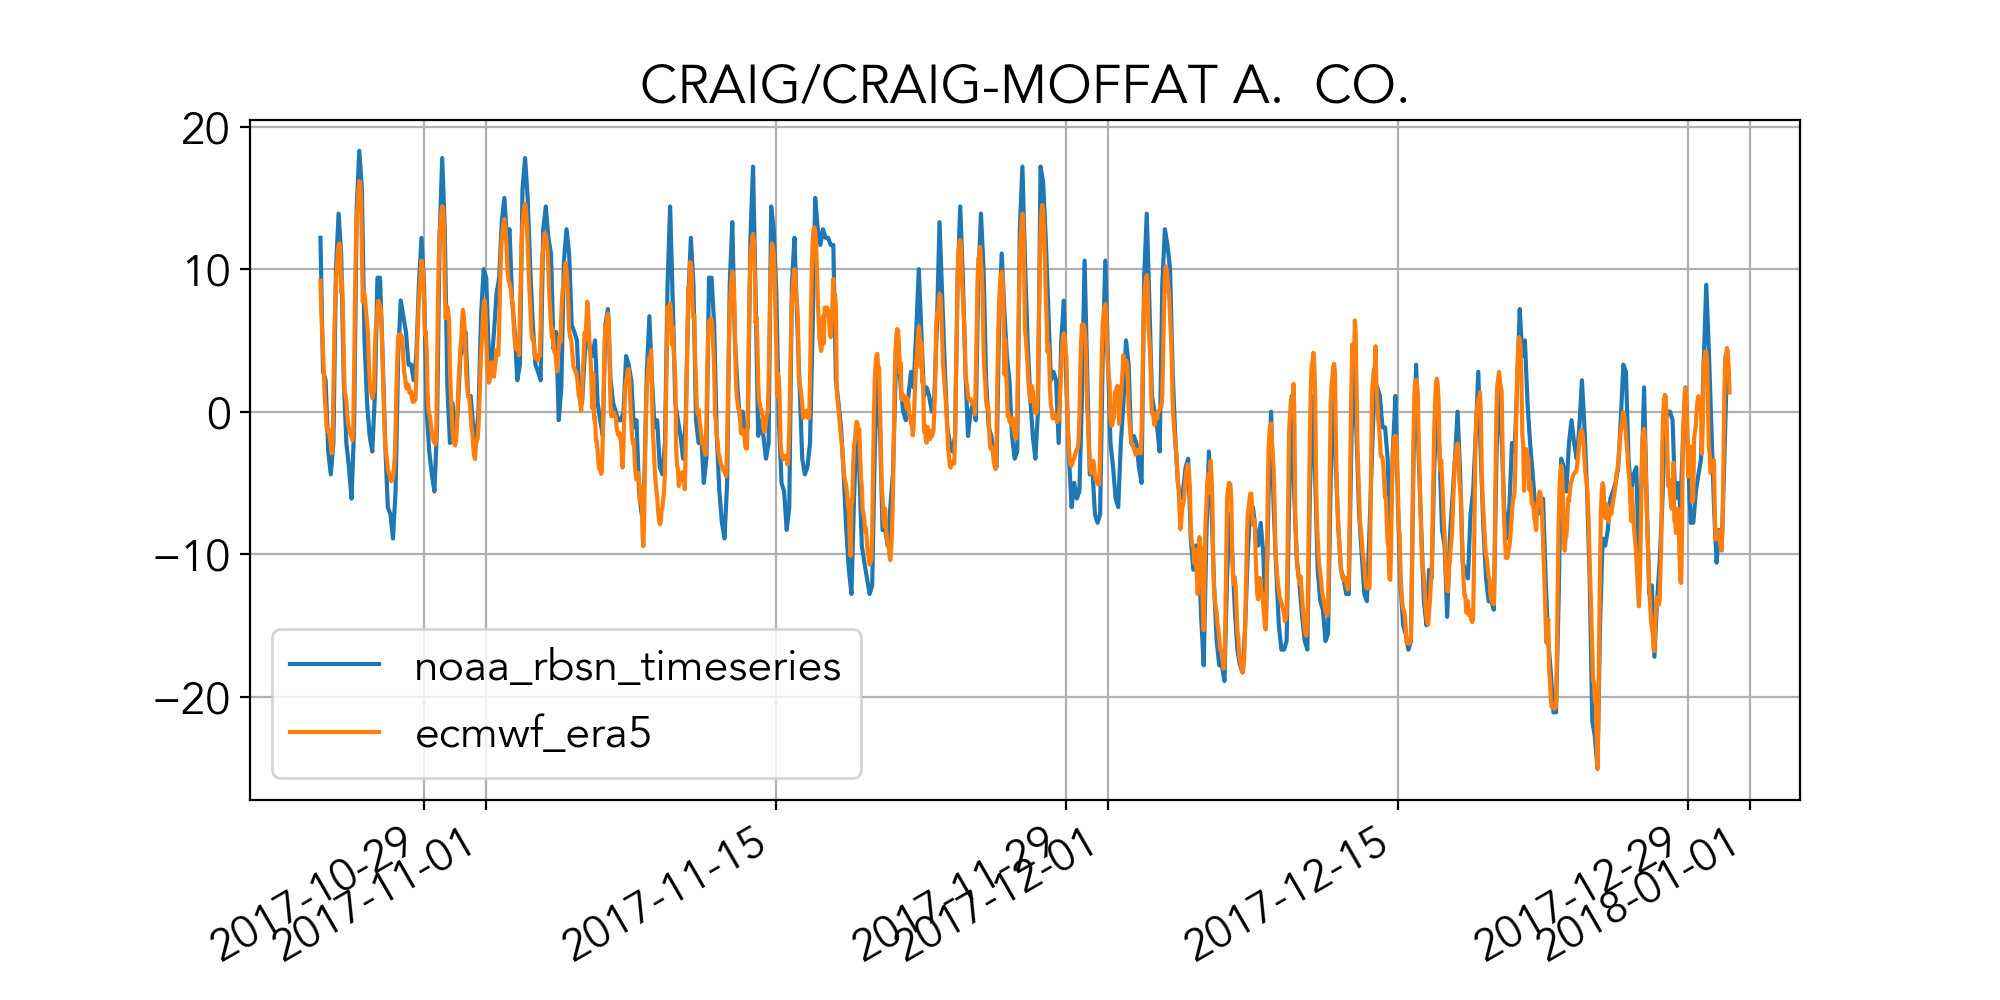

            ERA5    Station
Max    16.173425  18.299999
Mean   -1.437254  -1.264457
Min   -25.084448 -25.000000
Stdev   7.284047   8.205324


In [13]:
def compare_data(time1, data1, label1, time2, data2, label2, station):
    fig=plt.figure(figsize=(10, 5))
    plt.plot(time1, data1, label = label1)
    plt.plot(time2, data2, label = label2)
    plt.legend()
    plt.title(station)
    fig.autofmt_xdate()
    plt.grid()
    plt.show()

def print_statistics(data1, data2):
    pdict = {}
    for ddd in data1, data2:
        pdict[ddd[0]] = {"Mean" : np.mean(ddd[1]), 
                         "Stdev" : np.std(ddd[1]), 
                         "Max" : np.amax(ddd[1]), 
                        "Min" : np.amin(ddd[1])}
    print(pd.DataFrame(pdict))

    
selecter0 = widgets.Dropdown(
        options=droplist0,
        value=droplist0[0],
        description='Select station:',
        disabled=False,
        button_style=''
    )

def make_compare_plot(sender):
    clear_output()
    station = selecter0.value 
    station_data = rbsn_pd[rbsn_pd.station_name == station]
    print()
    station_data['date'] = pd.to_datetime(station_data['time'])
    ## era5_pd = get_data_from_point_API(dataset2, str(station_data.lon.values[0]), str(station_data.lat.values[0]), API_key,time_start = time_start,time_end = time_end, var=var_era5)

    compare_data(station_data.date,
                 station_data.temperature,
                 dataset1,
                 era5_pd[station].date,
                 era5_pd[station]['temp'],
                 dataset2,
                 station)
    print_statistics(('ERA5',era5_pd[station]['temp']), ('Station',station_data.temperature))
    display(selecter0)
    
selecter0.observe(make_compare_plot, names='value')
display(selecter0)